# TP parte 1

In [213]:
import pandas as pd
import numpy as np
import requests
from collections import Counter
import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
import seaborn as sns

#from sklearn.feature_extraction import FeatureHasher
#from sklearn.feature_selection import VarianceThreshold

#from sklearn.impute import KNNImputer, SimpleImputer
#from sklearn.preprocessing import (
    #KBinsDiscretizer,
    #LabelEncoder,
    #MinMaxScaler,
    #Normalizer,
    #OneHotEncoder,
    #OrdinalEncoder,
    #PowerTransformer,
    #RobustScaler,
    #StandardScaler,
#)

In [214]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("impuestos.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

# Introduccion 

El presente trabajo analizara determinados datos de personas que pagan impuestos brindados por una agencia gubernamental de recaudación de impuestos la FIUFIP con el objetivo de determinar si una persona posee altos ingresos o bajos ingresos.
La agencia tiene como principal objetivo determinar que individuos evaden los impuestos.

Los objetivos para este trabajo son
   * poder comprender los datos (viendolos y graficandolos)
   * ver como se relacionan entre ellos 
   * determinar patrones a partir de los graficos

Abrimos el data frame

In [215]:
df = pd.read_csv("impuestos.csv")

# Ingenieria de feautures  
Verificamos la calidad de los datos antes de visualizarlos.  

## Verificacion de datos faltantes
Primero verificamos aquellos valores que sean nulos. Con info() verificamos si los hay.

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      31978 non-null  object
 2   categoria_de_trabajo                        30725 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

Vemos que hay valores que nos faltan en la columna de trabajo, por ejemplo. Los pasamos todos a nan.

In [217]:
#aniadir mas chequeos??
df.fillna(np.nan, inplace = True)
df.isnull().sum()

anios_estudiados                                 0
barrio                                         583
categoria_de_trabajo                          1836
edad                                             0
educacion_alcanzada                              0
estado_marital                                   0
ganancia_perdida_declarada_bolsa_argentina       0
genero                                           0
horas_trabajo_registradas                        0
religion                                         0
rol_familiar_registrado                          0
tiene_alto_valor_adquisitivo                     0
trabajo                                       1843
dtype: int64

Dado que tenemos tres columnas con datos faltantes, tenemos que resolverlos de alguna manera.  
Para esto, tomamos las distintas decisiones:  
  *  Barrio: completamos con la media
  *  Categoria_de_trabajo: reempazamos los valores faltantes por "No respondio". falta justificacion
  *  Trabajo: completamos con la media

In [218]:
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].replace(np.nan, 'No inscripto')
df['trabajo'] = df['trabajo'].replace(np.nan, 'desempleado')#lo agreguge recien
categorias = df['categoria_de_trabajo'].value_counts(dropna=False)
trabajos = df['trabajo'].value_counts(dropna=False)
#categorias.head()
#trabajos.head()

Queremos observar cuantas personas no estan inscriptas ni tienen trabajo.

In [219]:
df.loc[(df['categoria_de_trabajo'] == 'No inscripto') & (df['trabajo'] == 'desempleado')].head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
27,14,Boedo,No inscripto,54,5_anio,matrimonio_civil,0,hombre,60,budismo,casado,1,desempleado
61,8,NaN,No inscripto,32,7-8_grado,pareja_no_presente,0,hombre,40,cristianismo,sin_familia,0,desempleado
69,14,Palermo,No inscripto,25,5_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,desempleado
77,10,Palermo,No inscripto,67,1_anio,matrimonio_civil,0,hombre,2,cristianismo,casado,0,desempleado
106,10,Palermo,No inscripto,17,1_anio,sin_matrimonio,34095,mujer,32,cristianismo,con_hijos,0,desempleado


observamos que son unas pocas personas las que no completaron ninguno de los dos campos. Es por eso que decidimos borralos del dataset

In [220]:
datos_a_borrar = (df['categoria_de_trabajo'] == 'No inscripto') &(df['trabajo'] == 'desempleado')
df = df.drop(df.loc[datos_a_borrar].index,axis=0).reset_index(drop=True)
            


Luego, decidimos complear las filas del atritubto barrio que estaban en null reemplazarlos por la media y tambien otamos por dejar lo que no respondienron con su trabajo pero si con su categoria como desempleados.

In [221]:
#mediana_barrio = df['barrio'].mean()
#mediana_barrio

df['barrio'] = df['barrio'].replace(np.nan, 'Otro Barrio')
#df.loc['barrio'] = df.loc['barrio'].fillna(mediana_barrio)

barrio = df['barrio'].value_counts(dropna=False)
barrio

Palermo                27511
Belgrano                 610
Otro Barrio              556
San Isidro               188
Villa Urquiza            128
La Boca                  109
Recoleta                 107
Almagro                  100
Agronomia                100
Balvanera                 92
Puerto Madero             86
Caballito                 80
Boedo                     71
Chacarita                 68
Barracas                  68
Coghland                  67
Floresta                  64
Constitucion              63
Colegiales                59
Flores                    56
Liniers                   56
Mataderos                 42
Monte Castro              42
Nueva Pompeya             42
Monserrat                 34
nuñez                     33
Parque Chacabuco          30
Parque Avellaneda         29
Villa Luro                27
Parque Chas               27
La Paternal               24
Retiro                    19
Villa Devoto              18
Villa Soldati             18
Villa Real    

Ahora verificamos valores negativos en aquellos feautures donde deberian ser todos positivos.

In [222]:
#ganancia perdida que onda?
columnas_con_numeros = ['edad', 'horas_trabajo_registradas']
print('con numeros negativos:')
(df[columnas_con_numeros] < 0).any()
#agregar chequeo de que en estas columnas solo hayan numeros

con numeros negativos:


edad                         False
horas_trabajo_registradas    False
dtype: bool

Vemos que no hay valores negativos en las edades ni en las horas trabajadas. (Nos falta chequear los valores que son numeros que no tengan strings)

Ahora verificamos si hay valores duplicados.

In [223]:
df[df.duplicated(keep=False)]

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
12,17,Palermo,relacion_de_dependencia,23,universidad_3_anio,sin_matrimonio,0,mujer,30,cristianismo,con_hijos,0,entretenimiento
17,13,Palermo,relacion_de_dependencia,32,4_anio,sin_matrimonio,0,hombre,40,cristianismo,soltero_a,0,inspector
20,20,Palermo,relacion_de_dependencia,40,universiada_6_anio,matrimonio_civil,0,hombre,60,cristianismo,casado,1,profesional_especializado
26,13,Palermo,relacion_de_dependencia,19,4_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,reparador
28,13,Palermo,relacion_de_dependencia,49,4_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,0,reparador
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30673,13,Palermo,relacion_de_dependencia,47,4_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,0,reparador
30682,13,Palermo,relacion_de_dependencia,20,4_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,inspector
30696,14,Palermo,relacion_de_dependencia,22,5_anio,sin_matrimonio,0,hombre,40,cristianismo,con_hijos,0,entretenimiento
30721,13,Palermo,relacion_de_dependencia,40,4_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,1,inspector


Podemos ver que hay varias columnas repetidas. Vemos que los valores que se repiten con mas frecuencia son el barrio donde reside cada persona, su categoria de trabajo, la religion y la perdida de ganancia. Concluimos que, dado que el resto de los datos varia, se trata de distintas personas.


## Conversion de variables  
Convertimos aquellas variables categoricas, ya sean ordinales y no ordinales. Empezamos por aquellas variables ordinales, las cuales son:  
    - First item educacion alcanzada

In [224]:
#unique_educacion_alcanzada = df['educacion_alcanzada'].value_counts(dropna=False)
#oe = OrdinalEncoder()
#columns_to_encode = ['educacion_alcanzada']
#try:
#    df[['educacion_alcanzada_encoded']] = oe.fit_transform(
 #       df[columns_to_encode]
 #   )
#except Exception as upa:
#    print(upa)

#print(unique_educacion_alcanzada)
#df['educacion_alcanzada_encoded']

Ahora vemos que las variables categoricas no ordinales son:
    -barrio
    -categoria_de_trabajo
    -

In [225]:
# Usando pandas profiling
report = ProfileReport(df, title='impuestos', explorative=True, lazy=False)
report

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

/home/sol/.local/lib/python3.8/site-packages/pandas_profiling/visualisation/plot.py:154: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu"))
  cmap.set_bad(cmap_bad)


Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [226]:
#Buscamos entender cada uno de los datos, cómo se relacionan entre sí y si se puede sacar alguna conclusión
#A partir de ellos vamos a determinar los factores que determinan si alguien tiene altos o bajos ingresos

# Visualizacion de datos   

## Primero nos hacemos una serie de preguntas para comprender y analizar mejor nuestros datos:  
 1. Influye la edad ?
 2. Influye el genero?
     - como esta relacionado con el rol familar o estado marital
 3. como se relaciona el poder adquitisitov con el trabajo? como afecta la categoria?
     - la cantidad de horas trabajadas esta relacionado con el tipo de oficio?
     - que relacion hay entre el tipo de trabajo de una persona con las ganacias perdidas en la bolsa 
 4. De que forma el lugar de residencia del individuo contribuye con el alto poder adquisitivo
 5. el nivel de estuidos alcanzados determina que una persona posea altos ingresos?
 
 


### Como esta relacionada el genero de una persona con su poder adquisitivo?
    

<AxesSubplot:ylabel='genero'>

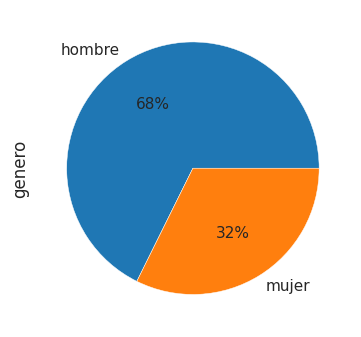

In [227]:
plt.figure(figsize=(5.4, 3.8), dpi=110)
df['genero'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)

Se puede observar que la mayoria de los encuentados fueron hombres. 
Intuimos que los que van a tener un mayor poder adquisitivo van a ser peronas del genero masculino. Para ver eso, calculamos el proporcion de personas que tienen altos ingresos. 

<AxesSubplot:ylabel='tiene_alto_valor_adquisitivo'>

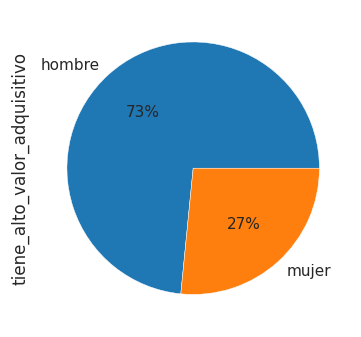

In [228]:
proporciones_adquisitivo = df.groupby(by='genero')['tiene_alto_valor_adquisitivo'].agg('mean')
total_personas_con_poder_adquisitivo = proporciones_adquisitivo['mujer'] + proporciones_adquisitivo['hombre']
proporciones_adquisitivo['hombre'] = proporciones_adquisitivo['hombre']/total_personas_con_poder_adquisitivo
proporciones_adquisitivo['mujer'] = proporciones_adquisitivo['mujer']/total_personas_con_poder_adquisitivo

plt.figure(figsize=(5.4, 3.8), dpi=110)
proporciones_adquisitivo.plot(
    kind='pie', autopct='%1.0f%%'
)

De por si, de los encuestados hay un bajo porcentaje que posee altos ingresos. De esa cantidad de personas podemos ver que es mayor el porcentaje de hombres que de mujeres los que tienen un alto poder adquisitivo como habiamos predicho en el grafico de tortas.

Queremos ver la relacion del trabajo con el alto o bajo poder adquisitivo

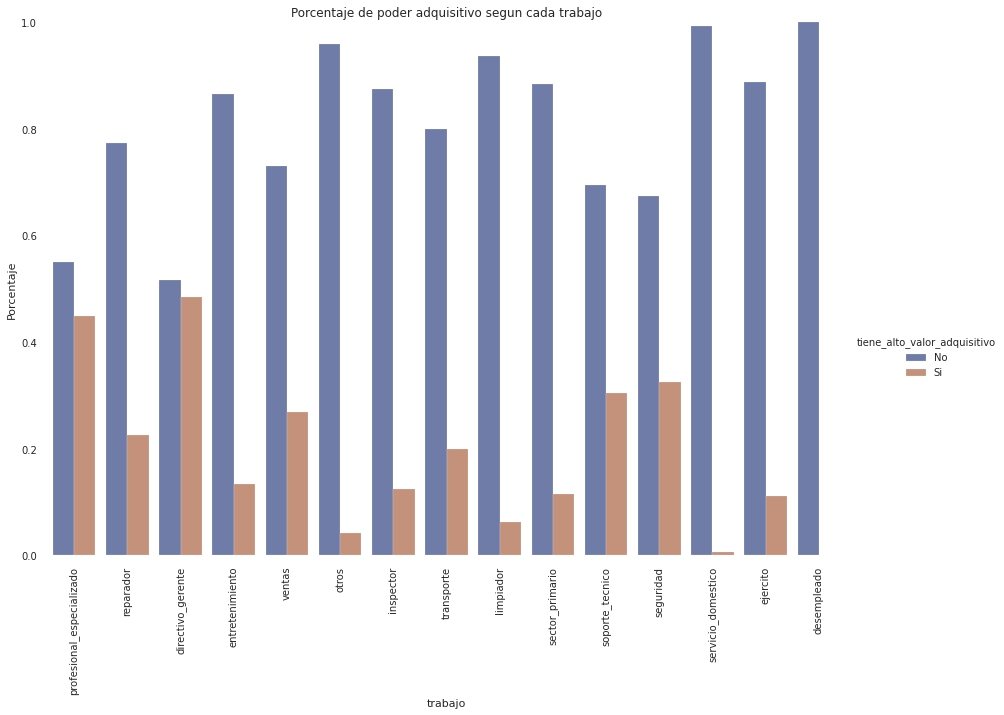

In [268]:
trabajo_por_poder_adq = df.groupby(by="trabajo")['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)

trabajo_por_poder_adq = trabajo_por_poder_adq.to_frame()
trabajo_por_poder_adq.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de respuestas'},inplace=True)
trabajo_por_poder_adq.reset_index(inplace=True)
trabajo_por_poder_adq['tiene_alto_valor_adquisitivo'].replace([0,1],['No','Si'],inplace=True)

g = sns.catplot(
    data=trabajo_por_poder_adq, kind="bar",
    x="trabajo", y="Cantidad de respuestas", hue="tiene_alto_valor_adquisitivo", order=df["trabajo"].value_counts().iloc[:20].index,
    ci=None, palette="dark", alpha=.6, height=8,aspect=1.5
)
plt.title("Porcentaje de poder adquisitivo segun cada trabajo")
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("trabajo", "Porcentaje")

Podemos ver que para todos los trabajos hay mas personas que consideran que no tienen un alto poder adquisitivo. Vemos que los que tienen un poder adquisitivo mayor y que se encuentran con porcentajes cercanos son profesional especializado y gerente directivo. Los que poseen menor poder adquisitivo son el servicio domestico, los desempleados y 'otros'.  
Ahora que visualizamos el valor adquisitivo segun el trabajo, queremos observar como se distribuyen los distintos empleos segun el genero.

In [ ]:
trabajo_por_genero = df.groupby(by="trabajo")['genero'].value_counts(normalize=True)
trabajo_por_genero = trabajo_por_genero.to_frame()
trabajo_por_genero.rename(columns={'genero':'Cantidad de respuestas'},inplace=True)
trabajo_por_genero.reset_index(inplace=True)

g = sns.catplot(
    data=trabajo_por_genero, kind="bar",
    x="trabajo", y="Cantidad de respuestas", hue="genero", order=df["trabajo"].value_counts().iloc[:20].index,
    ci=None, palette="colorblind", alpha=.6, height=8,aspect=1.5
)
plt.title("Porcentaje de trabajos segun genero")
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("trabajo", "Porcentaje")

Luego de ver como se relacionan el genero con el tipo de trabajo, concluimos que los trabajos con menor poder adquisitivo se distribuyen entre las mujeres, como por ejemplo los trabajos en el area de entretenimiento, servicio domestico y 'otros'.

Tambien observamos que los que tienen un mayor poder adquisitivo se distribuyen entre los hombres. Estos trabajos son los previamente mencionados, profesional especializado y directivo gerente.

Concluimos entonces que el bajo poder adquisitivo, en su mayoria entre las mujeres, se debe al trabajo realizado.  

## Es determinante el nivel de estudios alcanzados?

Queremos obtener una conclusion sobre que tan importante es el nivel de estudios alcanzados a la hora de determinar si una persona tiene altos ingresos. Primero queremos saber su relacion con el alto poder adquisitivo declarado por las personas encuestadas.  

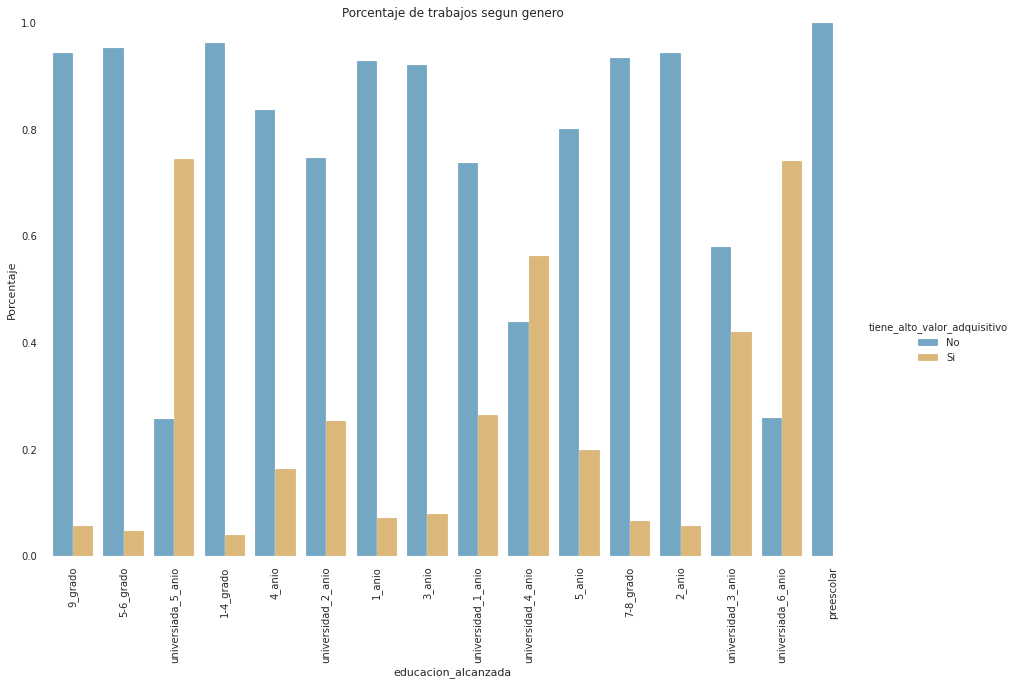

In [269]:
estudios_y_poder_adquisitivo = df.groupby(by="educacion_alcanzada")['tiene_alto_valor_adquisitivo'].value_counts(normalize=True)

estudios_y_poder_adquisitivo = estudios_y_poder_adquisitivo.to_frame()
estudios_y_poder_adquisitivo.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de respuestas'},inplace=True)
estudios_y_poder_adquisitivo.reset_index(inplace=True)
estudios_y_poder_adquisitivo['tiene_alto_valor_adquisitivo'].replace([0,1],['No','Si'],inplace=True)

g = sns.catplot(
    data=estudios_y_poder_adquisitivo, kind="bar",
    order=estudios_y_poder_adquisitivo["educacion_alcanzada"].value_counts().iloc[:20].index,
    x="educacion_alcanzada", y="Cantidad de respuestas", hue="tiene_alto_valor_adquisitivo", 
    ci=None, palette="colorblind", alpha=.6, height=8,aspect=1.5
)

plt.title("Porcentaje de trabajos segun genero")
g.despine(left=True)
plt.ylim(0,1)
plt.xticks(rotation=90)
g.set_axis_labels("educacion_alcanzada", "Porcentaje")

#ver si se puede ordenar

Podemos ver claramente que cuanto mayor sea el nivel de educacion alcanzado, mayor es el poder adquisitivo. Ademas dentro de los anios universitarios podemos ver diferencias significativas a medida que uno va avanzando en la carrera, siendo los anios mas altos los de mayor porcentaje de personas con alto poder adquisitivo.

Ahora queremos observar como se relaciona el nivel de educacion alcanzado con el trabajo realizado. Para esto, dividimos los niveles de educacion alcanzada en cuatro categorias:  
    - Preescolar  
    - Primario  
    - Secundario  
    - Universidad  

In [244]:
def agrupar_educacion_alcanzada(educacion):

    if educacion.find("universiada") >= 0:
        return "universitario"
    elif educacion.find("anio") >= 0:
        return "secundario"
    elif educacion.find("grado") >= 0:
        return "primario"
    else:
        return "preescolar"

In [275]:
estudios_alcanzados_y_trabajo = df.filter(['educacion_alcanzada', 'trabajo'],axis = 1)

estudios_alcanzados_y_trabajo['educacion_alcanzada'] = estudios_alcanzados_y_trabajo['educacion_alcanzada'].astype('string')
#estudios_alcanzados_y_trabajo['educacion_alcanzada'] = estudios_alcanzados_y_trabajo['educacion_alcanzada'].apply(agrupar_educacion_alcanzada)
                                                                                                                  
unique_educacion_alcanzada = estudios_alcanzados_y_trabajo['educacion_alcanzada'].value_counts(dropna=False)
unique_educacion_alcanzada

secundario       28227
primario          1496
universitario      956
preescolar          46
Name: educacion_alcanzada, dtype: int64

procedemos a realizar un heatmap para visualizar los datos

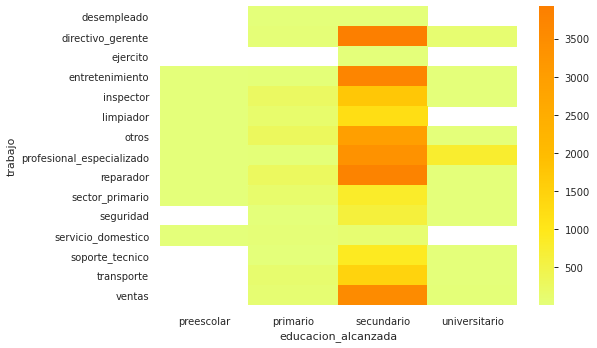

In [276]:
ct_counts = estudios_alcanzados_y_trabajo.groupby(['educacion_alcanzada', 'trabajo']).size()
ct_counts = ct_counts.reset_index(name = 'count')
ct_counts = ct_counts.pivot(index = 'trabajo', columns = 'educacion_alcanzada', values = 'count')
sns.heatmap(ct_counts, cmap="Wistia")
plt.show()

#Primero nos preguntamos cuales son los datos que nos van a ayudar a determinar lo pedido
#Para eso nos hacemos una serie de preguntas:

#DUDA: la educacion alcanzada-> cuando no aclara que tipo de educacion que hacemos.
#DUDA: hacer el promedio de cuantos anios dura una carrera, para tomar en cuenta sien funcion de su tiempo de estudio termino o no

#Influye la edad y el genero de la persona?

#Y sus  anios de educacion junto con el nivel de educacion alcanzado?

#Su estado marital junto con su religion? (posiblemente no)

#Vemos que los datos que pueden estar relacionados en cuanto a gastos mensuales son: barrio, rol familiar, o de la perdida en la Esto nos puede ayudar a 
#concluir si una persona tiene un alto poder adquisitivo.

#cuantas horas trabaja en relacion al trabajo que realiza y su categoria. (depende de la categoria lo que te sacan de impuestos)

#vemos que tenemos datos como la religion que no aporta informacion acerca del poder asquisitivo de una persona (consultar
#si se pueden volar los datos sin graficarlos)